In [5]:
import pandas as pd 
import numpy as np 
import os
import glob
import subprocess
from tqdm import tqdm
import itertools
import networkx as nx
import seaborn as sns
import matplotlib as mpl
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import math
import re
from utils import * 
from src.data import * 
import json
import sklearn
import io 

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# NOTE: I modified some of the plasmid file names for consistency with the metadata, e.g. pTiS4 to S4_ti
# TODO: What is the Atu or Avi prefix? Should I not have changed those?

metadata_df = load_weisberg_2020_metadata()

In [7]:
for path in glob.glob('../data/data-1/ncbi/genbank/*'):
    fasta_path = os.path.basename(path).replace('.gbk', '.fn')
    fasta_path = os.path.join('../data/data-1/ncbi/fasta/', fasta_path)
    if not os.path.exists(fasta_path):
        print(f'Writing FASTA nucleotide file to {fasta_path}')
        file = GBKFile(path)
        file.to_fasta(fmt='nt', path=fasta_path)

# Created HMM library by concatenating individual HMM filed into library.hmm.
# Had to manually-remove a string containing "ELEMENTS OF EXTERNAL ORIGIN;" because it caused issues with parsing. 
for path in tqdm(glob.glob('../data/data-1/ncbi/fasta/*'), 'Running HMMs on plasmids...'):
    source_id = os.path.basename(path).replace('.fn', '')
    output_path = f'../data/data-1/hmmer/{source_id}.tsv'
    if not os.path.exists(output_path):
        subprocess.run(f'nhmmer -E 10 --tblout {output_path} ../data/data-1/hmms/library.hmm {path}', shell=True, check=True, stdout=subprocess.DEVNULL)

Running HMMs on plasmids...: 100%|██████████| 142/142 [00:00<00:00, 76387.22it/s]


In [12]:
hmmer_df = load_hmmer_files(hmmer_dir='../data/data-1/hmmer')
overdrive_df = build_overdrive_dataset(overwrite=True, fasta_dir='../data/data-1/ncbi/fasta/', hmmer_df=hmmer_df, length=200, data_dir='../data/data-1/')
overdrive_df = overdrive_df.merge(metadata_df, left_on='source_id', right_on='source_id', how='left')
overdrive_df = overdrive_df[overdrive_df.plasmid_class == 'Ti'].copy() # Focus on Ti plasmids. 
overdrive_df = overdrive_df.set_index('id')

# Overwrite the existing dataset with only the Ti plasmids. 
overdrive_df.to_csv('../data/data-1/overdrive.csv')
FASTAFile(df=overdrive_df).write('../data/data-1/overdrive.fn')

# virc1_df = build_virc_dataset(plasmid_contig_ids=overdrive_df.contig_id.unique(), overwrite=False)
# virc2_df = build_virc_dataset(plasmid_contig_ids=overdrive_df.contig_id.unique(), overwrite=False, product='VirC2')
# overdrive_df['virc1_seq'] = overdrive_df.contig_id.map(virc1_df.set_index('contig_id').seq)
# overdrive_df['virc2_seq'] = overdrive_df.contig_id.map(virc2_df.set_index('contig_id').seq)


# FASTAFile(df=overdrive_df[overdrive_df.plasmid_class == 'Ti']).write('../data/data-1//overdrive_ti.fna')
# # FASTAFile(df=overdrive_df.dropna(subset='virc1_seq').drop(columns=['seq']).rename(columns={'virc1_seq':'seq'})).write('../data/virc1.faa')
# FASTAFile(df=overdrive_df.dropna(subset='virc2_seq').drop(columns=['seq']).rename(columns={'virc2_seq':'seq'})).write('../data/data-1/virc2.faa')

# # One strain (Di1411) has two annotated VirC1 because it has both an Ri and Ti plasmid. 

# overdrive_df

load_hmmer: Num. hits for query T-DNA_left_border: 296
load_hmmer: Num. hits for query T-DNA_right_border: 426
load_hmmer: Num. hits for query overdrive: 43
build_overdrive_dataset: Found 213 right borders.
build_overdrive_dataset: Found 142 FASTA files.


In [14]:
# def figure(hmmer_df:pd.DataFrame):

#     figure_df = hmmer_df.copy()
#     figure_df['has_t_dna'] = has_t_dna(figure_df) # Whether or not the DNA fragment has both a left and right border.
#     figure_df = figure_df.drop_duplicates('target_name')

#     fig, ax = plt.subplots()

#     palette = {False:'indianred', True:'darkseagreen'}
#     sns.kdeplot(figure_df, x='length', hue='has_t_dna', common_norm=True, palette=palette, ax=ax)
#     ax.set_xlim(xmin=0, xmax=300000)
#     ax.axvline(x=20000, ls='--', color='black', lw=0.7)

#     text = ''
#     for value, df in figure_df.groupby('has_t_dna'):
#         text += '$n_{' + str(value) + '}' + f'= {len(df)}$\n'
#     ax.text(0.5, 0.5, text, transform=ax.transAxes)

#     ax.set_ylabel('density')
#     plt.show()

# figure(hmmer_df)

In [15]:
# I am skeptical about making the assumption that the location of overdrive is conserved when creating the mutual
# information matrix, which is position-dependent. I wonder if there is some kind of 
# position-agnostic approach to this. Perhaps doing pairwise alignments of the entire upstream region?

# Secondary structure is likely not important for overdrive function, as its role is VirC binding, which occurs when the DNA is still 
# double-stranded. This suggests that importance is in the sequence, not any kind of structure. 

cols = ['query', 'target', 'evalue', 'pident', 'bits', 'qseq', 'tseq', 'alnlen', 'qstart', 'qend', 'tstart', 'tend']
align_df = pd.read_csv('../data/data-1/overdrive_align.tsv', sep='\t', header=None, names=cols)
align_df = align_df[align_df.bits > 50].copy()
align_df['start_offset'] = np.abs(align_df.qstart - align_df.tstart)
align_df['alignment_id'] = [' - '.join(sorted([row.target, row.query])) for row in align_df.itertuples()]
align_df = align_df[align_df['query'] != align_df['target']].copy() # Drop self-alignments.
align_df = align_df.sort_values('bits').drop_duplicates('alignment_id') # Drop duplicate alignments.

# All percent identities are high (>70%), so I think these alignments are reasonable. 

['JL5275_36:2504-2704', 'JL5275_36:195-395', 'JL5275_13:28669-28869', 'JL5275_13:39185-39385', 'JL5275_13:10101-10301', 'JL5275_13:39186-39386', 'JL5275_36:194-394', 'JL5275_13:28668-28868', 'JL5275_36:2503-2703', 'JL5280_13:35572-35772', 'JL5280_13:33263-33463', 'JL5280_13:68053-68253', 'JL5280_13:78569-78769', 'JL5280_13:49485-49685', 'JL5280_13:78570-78770', 'JL5280_13:33262-33462', 'JL5280_13:68052-68252', 'JL5280_13:35571-35771', 'AS1D6_11:45218-45418', 'AS1D6_11:68608-68808', 'AS1D6_11:45217-45417', 'JL5286_8:148586-148786', 'JL5286_8:146277-146477', 'JL5286_8:179743-179943', 'JL5286_8:190259-190459', 'JL5286_8:161175-161375', 'JL5286_8:190260-190460', 'JL5286_8:146276-146476', 'JL5286_8:179742-179942', 'JL5286_8:148585-148785', 'AS1E5_27:2504-2704', 'AS1E5_27:195-395', 'AS1E5_15:28669-28869', 'AS1E5_15:39185-39385', 'AS1E5_15:10101-10301', 'AS1E5_15:39186-39386', 'AS1E5_27:194-394', 'AS1E5_15:28668-28868', 'AS1E5_27:2503-2703', 'AS1F5_29:2504-2704', 'AS1F5_29:195-395', 'AS1F5_16

ValueError: 'c' argument has 698 elements, which is inconsistent with 'x' and 'y' with size 660.

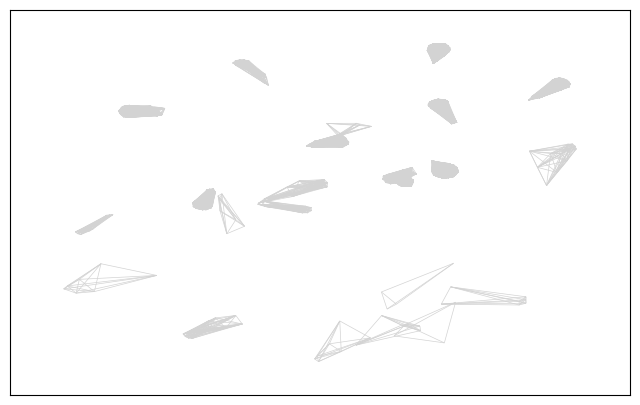

In [19]:
def figure(overdrive_df:pd.DataFrame, align_df:pd.DataFrame, field:str='plasmid_type'):

    figure_df = overdrive_df.copy()

    cmap = mpl.colormaps.get_cmap('tab20c')
    cmap = cmap.resampled(overdrive_df[~overdrive_df[field].str.contains('none')][field].nunique())
    palette = {f:cmap(i) for i, f in enumerate(overdrive_df[field].unique())} # Map each category to a color. 
    palette['none (none)'] = 'black'
    palette['none'] = 'black'

    plasmid_types = overdrive_df.plasmid_type.unique()
    ti_plasmid_types = sorted([plasmid_type for plasmid_type in plasmid_types if ('Ti' in plasmid_type)])
    ri_plasmid_types = sorted([plasmid_type for plasmid_type in plasmid_types if ('Ri' in plasmid_type)])
    plasmid_types = ti_plasmid_types + ri_plasmid_types + ['none (none)']
    figure_df['plasmid_type'] = pd.Categorical(figure_df.plasmid_type, categories=plasmid_types)
    figure_df = figure_df.sort_values('plasmid_type')

    graph = get_alignment_graph(align_df, order=overdrive_df.index.values)
    print(graph.nodes)

    fig, ax = plt.subplots(figsize=(8, 5))

    alignment_groups = list(nx.connected_components(graph))
    print('figure: Num. alignment groups:', len(alignment_groups))
    print('figure: Num. alignment groups > 1 member:', len([group for group in alignment_groups if (len(group) > 1)]))
    alignment_group_map = {id_:i for i, group in enumerate(alignment_groups) for id_ in group}

    # Only plot the non-singleton graphs. 
    is_ti_subgraph = lambda subgraph : np.all(overdrive_df.loc[list(subgraph)].plasmid_class == 'Ti')
    nodes = set()
    for subgraph in nx.connected_components(graph):
        if (len(subgraph) > 2) and is_ti_subgraph(subgraph):
            nodes.update(subgraph)
    graph = graph.subgraph(nodes).copy()

    pos = get_layout(graph)

    colors = get_graph_colors(graph, figure_df, field=field, palette=palette)
    print(palette)
    print(colors)
    nx.draw_networkx_edges(graph, ax=ax, pos=pos, edge_color='lightgray', width=0.5)
    nx.draw_networkx_nodes(graph, ax=ax, node_size=15, pos=pos, edgecolors='black', node_color=colors, linewidths=0.5)

    legend_labels = overdrive_df.loc[list(graph.nodes)][field].unique()
    legend_handles = [mpl.lines.Line2D([None], [None], ls='none', markersize=5, marker='o', markeredgewidth=0.5, markeredgecolor='black', markerfacecolor=palette.get(label)) for label in legend_labels]
    ax.legend(legend_handles, legend_labels, fontsize='xx-small', bbox_to_anchor=(1.05, 1.05))

    for _, spine in ax.spines.items():
        spine.set_visible(False)

    plt.show()
    return palette, alignment_group_map

palette, alignment_group_map = figure(overdrive_df, align_df)

Num. alignments both starting at position 1: 7020


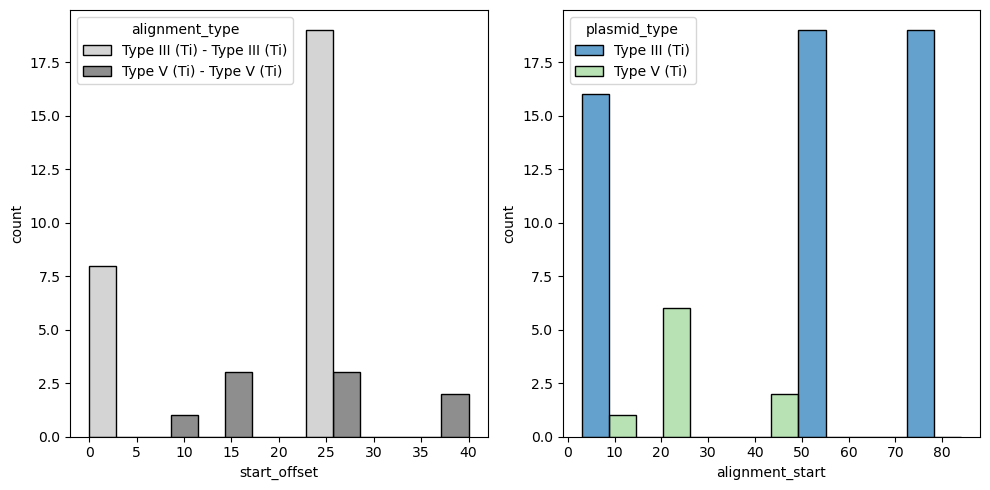

In [ ]:
def figure(overdrive_df, align_df, palette:dict=palette):

    figure_df = align_df.copy()
    figure_df['target_plasmid_type'] = align_df['target'].map(overdrive_df.plasmid_type)
    figure_df['query_plasmid_type'] = align_df['query'].map(overdrive_df.plasmid_type)
    figure_df['start_offset'] = np.abs(figure_df.qstart - figure_df.tstart)
    fig, (ax_a, ax_b) = plt.subplots(ncols=2, figsize=(10, 5))

    n_alignments_both_starting_at_1 = ((figure_df.qstart == 1) & (figure_df.tstart == 1)).sum()
    print('Num. alignments both starting at position 1:', n_alignments_both_starting_at_1)

    ax_df = figure_df[~((figure_df.qstart == 1) & (figure_df.tstart == 1))].copy()
    ax_df[ax_df.target_plasmid_type != ax_df.query_plasmid_type][['target_plasmid_type', 'query_plasmid_type', 'qstart', 'tstart', 'qend', 'tend']]
    ax_df['alignment_type'] = [' - '.join(sorted([row.query_plasmid_type, row.target_plasmid_type])) for row in ax_df.itertuples()]
    sns.histplot(ax_df, x='start_offset', hue='alignment_type', palette='Grays', multiple='dodge', ax=ax_a)

    ax_df = pd.DataFrame(index=pd.Series(np.concatenate([figure_df[figure_df.qstart > 1]['query'].values, figure_df[figure_df.tstart > 1]['target'].values]), name='id'))
    ax_df['alignment_start'] = np.concatenate([figure_df[figure_df.qstart > 1]['qstart'].values, figure_df[figure_df.tstart > 1]['tstart'].values])
    ax_df['plasmid_type'] = np.concatenate([figure_df[figure_df.qstart > 1]['query_plasmid_type'].values, figure_df[figure_df.tstart > 1]['target_plasmid_type'].values])
    sns.histplot(ax_df, x='alignment_start', hue='plasmid_type', palette=palette, multiple='dodge', ax=ax_b)

    ax_a.set_ylabel('count')
    ax_b.set_ylabel('count')
    fig.tight_layout()
    plt.show()

figure(overdrive_df, align_df)
# We observe inconsistent alignment start locations. It could be that the overdrive sequences are at different locations relative to the
# right border in different plasmids. However, we also see that many of the plasmids have multiple annotated right borders. 
# Based on Alex's paper, it seems possible that recombination disrupted the region around the right border, possibly resulting
# in poor conservation and inactive T-DNA. 

In [ ]:
# # It seems like locating some kind of common motif is essential for further analysis, based on uncertainty regarding the presence
# # and/or starting location of the overdrive sequence. Preliminary analysis shows that an exact match for the consensus sequence
# # identified by Shurvinton and Ream  (1991) is only present in ~40 of the plasmids. I decided to try a motif search with
# # the MEME software suite.
# # 
# # Worth noting that I used the OOPS (one occurrence per sequence) assumption, although not every sequence has an occurrence of the motif. 
# # Not sure if running with a different assumption (e.g. ZOOPS) would change the results, or if this was the best choice considering that
# # there is not one occurrence per sequence. 

# # meme overdrive_ti.fna -dna -oc . -nostatus -time 14400 -mod oops -nmotifs 3 -minw 5 -maxw 8 -objfun classic -markov_order 0

# # The MAST output file contains the identified motifs in each sequence. 
# overdrive_mast_df = read_csv_chunk('../data/data-1/overdrive_ti_mast.txt', names=['id', 'e_value', 'motif_diagram'])
# overdrive_mast_df['strain_id'] = overdrive_mast_df['id'].str.replace(r'_\d+-\d+', '', regex=True)
# overdrive_mast_df['source_id'] = [f'{strain_id}_ti' for strain_id in overdrive_mast_df['strain_id']]
# for i in [1, 2, 3]:
#     overdrive_mast_df[f'has_motif_{i}'] = overdrive_mast_df.motif_diagram.str.contains(f'{i}]', regex=False)
#     overdrive_df[f'has_motif_{i}'] = overdrive_df.index.map(overdrive_mast_df[f'has_motif_{i}'])

# overdrive_ti_df = overdrive_df[overdrive_df.plasmid_class == 'Ti']
# print('Num. Ti plasmids:', overdrive_ti_df.source_id.nunique(), end='\n\n')

# for i in [1, 2, 3]:
#     n = overdrive_mast_df.groupby('source_id').apply(lambda df : np.any(df[f'has_motif_{i}']), include_groups=False).sum()
#     print(f'Num. Ti plasmids with motif {i}:', n)

# overdrive_motif_1_df = read_csv_chunk('../data/data-1/overdrive_ti_meme.txt', names=['id', 'start', 'p_value', 'site_1', 'site_2', 'site_3'], start_line=296, end_line=694)
# motif_1 = overdrive_motif_1_df.site_2.iloc[0]
# overdrive_motif_1_df.sort_values('p_value', ascending=False)

# with open('../data/data-1/overdrive_ti_motif_1.fna', 'w') as f:
#     content = ''
#     for row in overdrive_motif_1_df.itertuples():
#         content += f'>{getattr(row, 'id')}\n'

#         seq = f'{row.site_1}{row.site_2}{row.site_3}'.replace('.', '')
#         content += f'{seq}\n'
#     f.write(content)

# # The motif seems to be the same as that identified by Shurvinton and Ream. It (or a variation) is identified at least once in every Ti plasmid
# # It is unclear if the region to the left or right of the consensus is important for overdrive functionality. Notably, some of the identified motifs
# # are immediately adjacent to the right border, which seems to imply that the left region is not universally important. 
# print('\nMotif 1:', motif_1, f'({overdrive_motif_1_df.site_2.nunique()} variants)')


In [ ]:
# Write the detected motifs to a FASTA file and build an HMM. 
overdrive_motif_1_df['seq'] = [f'{row.site_1}{row.site_2}{row.site_3}'.replace('.', '') for row in overdrive_motif_1_df.itertuples()]
FASTAFile(df=overdrive_motif_1_df.set_index('id')).write('../data/data-1/overdrive_motif_1.fna')

# ! /home/prichter/muscle5.1.linux_intel64 -align ../data/data-1/overdrive_motif_1.fna -output ../data/data-1/overdrive_motif_1.afn
# ! hmmbuild ../data/data-2/overdrive.hmm ../data/data-1/overdrive_motif_1.afn

In [ ]:
# Going to see if there are any motifs at all. 
# ! /home/prichter/muscle5.1.linux_intel64 -align ../data/overdrive.fna -output ../data/overdrive.afn

In [ ]:
# How to go about the mutual information analysis:
# (1) Look at the alignment groups of the RB upstream sequences and try to generate an MSA. 
# (2) Align the VirC2 from the corresponding assemblies. 

# There are multiple overdrive sequences and VirC1s in certain strains, so might want to consider every possible pair. 

# TODO: I don't think there are enough sequences to do reliable mutual information analysis (< 100 sequences in every alignment group).
# Might need to look in the NCBI database for more sequences. 

# def build_paired_msa(alignment_group:int=5, virc_dataset_df:pd.DataFrame=virc_dataset_df, overdrive_df:pd.DataFrame=overdrive_df, data_dir:str='../data/msa'):
    
#     msa_df = list()

#     overdrive_df = overdrive_df[overdrive_df.alignment_group == alignment_group].copy()
#     virc_dataset_df = virc_dataset_df[virc_dataset_df['product'].str.contains('virc1', case=False)].copy()

#     strain_ids = overdrive_df.strain_id.unique()
#     for strain_id in strain_ids:
#         od_seqs = overdrive_df[overdrive_df.strain_id == strain_id].seq.values 
#         virc1_seqs = virc_dataset_df[virc_dataset_df.strain_id == strain_id].seq.values 
#         for od_seq, virc1_seq in itertools.product(od_seqs, virc1_seqs):
#             msa_df.append({'virc1_seq':virc1_seq, 'od_seq':od_seq, 'strain_id':strain_id})

#     msa_df = pd.DataFrame(msa_df) # DataFrame contains rows of interaction pairs. 
#     msa_df.index = msa_df.index.astype(str)

#     FASTAFile(df=msa_df.rename(columns={'od_seq':'seq'})).write(f'{data_dir}/od_{alignment_group}.fna')
#     FASTAFile(df=msa_df.rename(columns={'virc1_seq':'seq'})).write(f'{data_dir}/virc1_{alignment_group}.faa')

#     cmd = '/home/prichter/muscle5.1.linux_intel64'
#     if not os.path.exists(f'{data_dir}/od_{alignment_group}.afn'):
#         subprocess.run(f'{cmd} -align {data_dir}/od_{alignment_group}.fna -output {data_dir}/od_{alignment_group}.afn', shell=True, check=True, stdout=subprocess.DEVNULL)
#     if not os.path.exists(f'{data_dir}/virc1_{alignment_group}.afa'):
#         subprocess.run(f'{cmd} -align {data_dir}/virc1_{alignment_group}.faa -output {data_dir}/virc1_{alignment_group}.afa', shell=True, check=True, stdout=subprocess.DEVNULL)

#     paired_msa_df = FASTAFile(path=f'{data_dir}/od_{alignment_group}.afn').to_df().rename(columns={'seq':'seq_a'})
#     paired_msa_df = pd.concat([paired_msa_df, FASTAFile(path=f'{data_dir}/virc1_{alignment_group}.afa').to_df().rename(columns={'seq':'seq_b'})], axis=1)
#     paired_msa_df = paired_msa_df.drop(columns=['description'])
#     return paired_msa_df


# paired_msa_df = build_paired_msa()

In [ ]:
# has_rb_and_od = lambda df : np.any(df.query_name.str.contains('right_border')) or np.any(df.query_name.str.contains('overdrive'))

# def get_hmmer_overdrive_info():
#     hmmer_df = pd.concat([HMMerFile(path).to_df() for path in glob.glob('../data/hmmer/*')])
#     hmmer_df['length'] = np.where(hmmer_df.strand == '+', hmmer_df.target_to - hmmer_df.target_from, hmmer_df.target_from - hmmer_df.target_to)
#     hmmer_df['length'] = hmmer_df.length + 1 # Add one for the indexing. 

#     df = list()
#     for contig_id, hmmer_df_ in hmmer_df.groupby('target_name'): # Group by hits which are on the same contig. 
#         # Going to want to filter out all of the distances which are outliers, these will be due to the fact that there might be multiple
#         # overdrive sequences and RBs in a single plasmid. 
#         rb_rows = list(hmmer_df_[hmmer_df_.query_name.str.contains('right_border')].itertuples()) # Overdrive sequences are adjacent to the right border. 
#         od_rows =  list(hmmer_df_[hmmer_df_.query_name.str.contains('overdrive')].itertuples())

#         for rb_row, od_row in itertools.product(rb_rows, od_rows):
#             if rb_row.strand != od_row.strand:
#                 continue # Must be on the same strand. 
#             if (rb_row.strand == '+'):
#                 d = od_row.target_from - rb_row.target_to
#             elif (rb_row.strand == '-'):
#                 d = rb_row.target_to - od_row.target_from
#             df.append({'contig_id':contig_id, 'dist_from_rb':d, 'strand':rb_row.strand, 'od_length':od_row.length}) 
    
#     df = pd.DataFrame(df)
#     df = df[(df.dist_from_rb > 0)].copy() # Remove anything negative, which I don't think should happen. 
#     df = df.sort_values('dist_from_rb').drop_duplicates('contig_id', keep='first') # Pick the sequence with the smallest separation on each contig. 
#     return df

# get_hmmer_overdrive_info()

In [ ]:
# The upstream regions are too highly-conserved amongst the alignment groups to do reasonable analysis with mutual information. 
# Most of the positions have zero entropy (i.e. contain no usable information) because they are all identical. Also, the alignment
# groups are far too small. 

# Because there is uncertainty about where the overdrive sequence might start, it doesn't makes sense to use the entire
# upstream region. You'd basically be asking "which positions in the upstream region are associated with which residues in VirC, and 
# if we think the location of the overdrive sequence is not conserved, this won't be interpretable. 

# fig, ax = plt.subplots()

# cmap = mpl.colormaps.get_cmap('tab20c')
# cmap = cmap.resampled(3)
# # palette = [cmap(i) for i in np.linspace(0, 1, metadata_df[field].dropna().nunique())] # Get colors for the palette.
# palette = {biovar:cmap(i) for i, biovar in enumerate(['BV1', 'BV2', 'BV3'])} # Map each category to a color. 

# figure_df = metadata_df[metadata_df.biovar.isin(['BV1', 'BV2', 'BV3'])].copy()
# figure_df = figure_df[figure_df.plasmid_class == 'Ti'].copy()
# sns.histplot(figure_df, x='plasmid_type', hue='biovar', multiple='dodge', palette=palette, ax=ax)
# ax.set_xticks(np.arange(len(ax.get_xticklabels())), labels=ax.get_xticklabels(), rotation=45)
# plt.show()


In [ ]:
# # ! mmseqs easy-cluster ../data/virc1.faa ../data/mmseqs/virc1 ../data/mmseqs/tmp/ --min-seq-id 0.99
# virc1_cluster_df = pd.read_csv('../data/mmseqs/virc1_cluster.tsv', sep='\t', header=None, names=['cluster_rep', 'id'])
# virc1_cluster_df['cluster_id'] = virc1_cluster_df.cluster_rep.map({id_:f'virc1_group_{i}' for i, id_ in enumerate(virc1_cluster_df.cluster_rep.unique())})
# print('Num. VirC1 clusters:', virc1_cluster_df.cluster_rep.nunique())

# overdrive_df['virc1_cluster_id'] = overdrive_df.index.map(virc1_cluster_df.set_index('id').cluster_id)
# overdrive_df['virc1_cluster_id'] = overdrive_df.virc1_cluster_id.fillna('none')

# # ! mmseqs easy-cluster ../data/virc2.faa ../data/mmseqs/virc2 ../data/mmseqs/tmp/ --min-seq-id 0.99
# virc2_cluster_df = pd.read_csv('../data/mmseqs/virc2_cluster.tsv', sep='\t', header=None, names=['cluster_rep', 'id'])
# virc2_cluster_df['cluster_id'] = virc2_cluster_df.cluster_rep.map({id_:f'virc2_group_{i}' for i, id_ in enumerate(virc2_cluster_df.cluster_rep.unique())})
# print('Num. VirC2 clusters:', virc2_cluster_df.cluster_rep.nunique())

# overdrive_df['virc2_cluster_id'] = overdrive_df.index.map(virc2_cluster_df.set_index('id').cluster_id)
# overdrive_df['virc2_cluster_id'] = overdrive_df.virc2_cluster_id.fillna('none')